In [1]:
import sys
sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch.optim as optim
from tqdm import tqdm

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(ResidualBlock, self).__init__()
        self.dilated_conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=dilation, dilation=dilation)
        self.batch_norm1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dilated_conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=dilation, dilation=dilation)
        self.batch_norm2 = nn.BatchNorm1d(out_channels)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = self.dilated_conv1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.dilated_conv2(out)
        out = self.batch_norm2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        return self.relu(out + residual)

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.dense1 = nn.Linear(in_channels, out_channels)
        self.batch_norm1 = nn.BatchNorm1d(out_channels)
        self.dense2 = nn.Linear(out_channels, out_channels)
        self.batch_norm2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.dense1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.dense2(out)
        out = self.batch_norm2(out)
        return out

class DeepTCN(nn.Module):
    def __init__(self, num_series, num_outputs, num_blocks, kernel_size, hidden_channels, num_covariates):
        super(DeepTCN, self).__init__()
        self.num_covariates = num_covariates
        layers = []
        for i in range(num_blocks):
            dilation_size = 2 ** i
            in_channels = num_series if i == 0 else hidden_channels
            layers += [ResidualBlock(in_channels, hidden_channels, kernel_size, dilation_size)]

        self.encoder = nn.Sequential(*layers)
        self.decoder = Decoder(hidden_channels + num_covariates, hidden_channels)
        self.output_layer = nn.Linear(hidden_channels, 1)

    def forward(self, x, covariates):
        # Encoder
        x = x.permute(0, 2, 1)  # Assuming input of shape [batch, seq_len, features]
        x = self.encoder(x)

        # Decoder
        x = x.mean(dim=2)  # Global average pooling

        outputs = []

        for seq_len_idx in range(covariates.shape[1]):
            current_covariate = covariates[:, seq_len_idx, :]
            combined = torch.cat((x, current_covariate), dim=1)
            decoded = self.decoder(combined)
            outputs.append(decoded)

        outputs = torch.stack(outputs, dim=1)
        outputs = self.output_layer(outputs)
        outputs = outputs.squeeze(-1)
        return outputs

In [3]:
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
# import metarhandler

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


# Function to create sequences
# output_seq_len <= input_seq_len
def create_sequences_new(data, features, target, input_seq_len, output_seq_len, shuffle=True, rand_state=42):
    input_seq = []
    output_seq = []
    flight_ids = data['flight'].unique()

    for id in flight_ids:
        flight_input_data = data[data['flight'] == id][features].values
        flight_output_data = data[data['flight'] == id][target].values
        for i in range(len(flight_input_data) - input_seq_len - output_seq_len):
            input_seq.append(flight_input_data[i:i+input_seq_len])
            output_seq.append(flight_output_data[i+input_seq_len : i+input_seq_len+output_seq_len])

    if shuffle:
        combined = list(zip(input_seq, output_seq))
        random.Random(rand_state).shuffle(combined)
        input_seq, output_seq = zip(*combined)
        input_seq = list(input_seq)
        output_seq = list(output_seq)

    return np.array(input_seq), np.array(output_seq)

def create_sequences(input_data, output_data, input_seq_len, output_seq_len):
    input_seq = []
    output_seq = []
    for i in range(len(input_data) - input_seq_len - output_seq_len):
        input_seq.append(input_data[i:i+input_seq_len])
        output_seq.append(output_data[i+input_seq_len : i+input_seq_len+output_seq_len])
    return np.array(input_seq), np.array(output_seq)

def create_dataloaders(data, input_seq_len, output_seq_len, test_size, val_size, batch_size, rand_state,
                       target:str, features:list=None, covariates:bool=False):
    # Generate Input and Output Sequences
    if features is None:
        features = getFeatures()
    if covariates:
        features = features + ['x_future','y_future','z_future']
    assert target in features, "Target must be in features"
    input_seq, output_seq = create_sequences(data[features].values,data[target].values, input_seq_len, output_seq_len)

    # print(data["energy_consumed"].values)

    # Split the data into training, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(input_seq, output_seq, test_size=test_size, random_state=rand_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=rand_state)  # 0.25 x 0.8 = 0.2

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # create dataloader
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    val_data = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def create_dataloaders_by_flights(data, input_seq_len, output_seq_len, test_size, val_size, batch_size, rand_state,
                                  target: str, features: list=None, covariates: bool=False):
    ##
    # Getting data sets by unique flights
    uniq_flights = data['flight'].unique().tolist()
    num_flights = len(uniq_flights)

    # By paper, [268, 269, 270, 271, 272, 273, 276, 277, 278, 279] are random flights and included in test set
    force_test_flights = [268, 269, 270, 271, 272, 275, 276, 277, 278, 279]
    uniq_flights = list(set(uniq_flights) - set(force_test_flights))

    # Split the flights into training, validation, and test sets
    random.Random(rand_state).shuffle(uniq_flights)
    num_other_tests = max(0, round(num_flights * test_size) - 10)
    test_flights = uniq_flights[:num_other_tests] + [268, 269, 270, 271, 272, 275, 276, 277, 278, 279]

    num_val_flights = round(num_flights * val_size)
    val_flights = uniq_flights[num_other_tests:num_other_tests + num_val_flights]

    train_flights = uniq_flights[num_other_tests + num_val_flights:]

    d_split = {'train': train_flights, 'val': val_flights, 'test': test_flights}

    # # Split the data into training, validation, and test sets
    # train_flights, test_flights = train_test_split(uniq_flights, test_size= test_size, random_state=rand_state)
    # train_flights, val_flights = train_test_split(train_flights, test_size = val_size, random_state=rand_state)

    train_data = data[data['flight'].isin(train_flights)]
    val_data = data[data['flight'].isin(val_flights)]
    test_data = data[data['flight'].isin(test_flights)]
    # print("TRAIN DATA")
    # print(train_data)

    # print("VAL DATA")
    # print(val_data)

    # print("TEST DATA")
    # print(test_data)
    # Generate Input and Output Sequences

    assert target in features, "Target must be in features"

    train_input_seq, train_output_seq = create_sequences_new(train_data, features, target, input_seq_len, output_seq_len, shuffle=True, rand_state=rand_state)
    val_input_seq, val_output_seq = create_sequences_new(val_data, features, target, input_seq_len, output_seq_len, shuffle=True, rand_state=rand_state)
    test_input_seq, test_output_seq = create_sequences_new(test_data, features, target, input_seq_len, output_seq_len, shuffle=True, rand_state=rand_state)

    # Convert to PyTorch tensors
    X_train = torch.tensor(train_input_seq, dtype=torch.float32)
    y_train = torch.tensor(train_output_seq, dtype=torch.float32)
    X_val = torch.tensor(val_input_seq, dtype=torch.float32)
    y_val = torch.tensor(val_output_seq, dtype=torch.float32)
    X_test = torch.tensor(test_input_seq, dtype=torch.float32)
    y_test = torch.tensor(test_output_seq, dtype=torch.float32)

    # create dataloader
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    val_data = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    return train_loader, val_loader, test_loader, d_split
    ##



def parse_altitude(altitude_str):
    altitude_str = str(altitude_str)
    altitudes = [int(alt) for alt in altitude_str.split('-')]
    max_altitude = max(altitudes)
    min_altitude = min(altitudes)
    mean_altitude = sum(altitudes) / len(altitudes)
    return pd.Series([max_altitude, min_altitude, mean_altitude], index=['max_altitude', 'min_altitude', 'mean_altitude'])


def calculate_consumptions(dataset):

    # Calculate the time difference between each measurement
    dataset['time_diff'] = dataset.groupby('flight')['time'].diff().fillna(0)

    # Calculate current consumed in each interval (Coulombs = Amperes * Seconds)
    dataset['current_atm'] = dataset['battery_current'] * dataset['time_diff']

    # Calculate energy consumed in each interval (Coulombs = Amperes * Seconds)
    dataset['energy_atm'] = dataset['battery_current'] *dataset['battery_voltage']* dataset['time_diff']

    # Calculate the cumulative current consumption
    dataset['current_consumed'] = dataset.groupby('flight')['current_atm'].cumsum()

    # Calculate the cumulative energy consumption
    dataset['energy_consumed'] = dataset.groupby('flight')['energy_atm'].cumsum()
    return dataset

def calculate_diff(group, step_into_future):
    group['x_change'] = group['position_x'].shift(-step_into_future) - group['position_x'].shift(-step_into_future+1)
    group['y_change'] = group['position_y'].shift(-step_into_future) - group['position_y'].shift(-step_into_future+1)
    group['z_change'] = group['position_z'].shift(-step_into_future) - group['position_z'].shift(-step_into_future+1)
    return group

def calculate_futures(dataset, step_into_future = 12):
    dataset['x_future'] = dataset.groupby('flight')['position_x'].shift(-step_into_future)
    dataset['y_future'] = dataset.groupby('flight')['position_y'].shift(-step_into_future)
    dataset['z_future'] = dataset.groupby('flight')['position_z'].shift(-step_into_future)
    dataset = dataset.groupby('flight').apply(lambda group: calculate_diff(group, step_into_future))

    dataset = dataset.dropna()
    return dataset


def get_data_loaders(data, input_seq_len = 10, output_seq_len = 2,
    test_size = 0.2,
    val_size = 0.25,
    batch_size = 64,
    rand_state = 42,
    target = 'power',
    trim:float=None,
    features:list=None,
    covariates:bool=False,
    scale:bool=True):
    # Read the data from the CSV file
    # data = pd.read_csv('flights.csv')

    #Drop broken data records for flight 211 -219
    flights_to_remove = [211,212,213,214,215,216,217,218,219]
    data = data[~data['flight'].isin(flights_to_remove)]

    # Apply the function to the altitude column and join with the original dataframe
    altitude_features = data['altitude'].apply(parse_altitude)
    data = data.join(altitude_features)
    # Now remove the original 'altitude' column as it's been replaced with numeric features
    data.drop('altitude', axis=1, inplace=True)

    #Convert Route ID to number 0-10
    data['route'] = data['route'].replace(['R1','R2','R3','R4','R5','R6','R7','A1','A2','A3','H'],[0,1,2,3,4,5,6,7,8,9,10])
    #Remove 'date' and 'time-day' from the dataset
    data.drop(['date','time_day'], axis = 1, inplace = True)
    #calculating power consumption (W)
    data['power'] = data['battery_voltage'] * data['battery_current']

    #calculation current consumption (Amp * s)
    data = calculate_consumptions(data)
    if covariates:
        data = calculate_futures(data, input_seq_len)

    # TODO: add air density as a feature (refer to paper code)

    if features is None:
        features = getFeatures()

    if covariates:
        features = features + ['x_future','y_future','z_future'] + ['x_change', 'y_change', 'z_change']

    print(features)
    # Apply MinMaxScaler to the features except time & flight
    if scale:
        scaler = MinMaxScaler()
        data[features] = scaler.fit_transform(data[features])

    #Create Data loaders

    train_loader, val_loader, test_loader, d_split = create_dataloaders_by_flights(data, input_seq_len, output_seq_len, test_size, val_size, batch_size, rand_state, target,
                                                                           features)
    return data, train_loader, val_loader, test_loader, d_split

def getFeatures(covariates = False):
    if covariates:
        return ['wind_speed','wind_angle','battery_voltage', 'battery_current', 'position_x', 'position_y', 'position_z',
                                    'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w', 'velocity_x', 'velocity_y', 'velocity_z',
                                    'angular_x', 'angular_y', 'angular_z','linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z',
                                    'speed', 'payload', 'max_altitude', 'min_altitude', 'mean_altitude','route','power','time_diff','current_atm',
                                    'energy_atm','current_consumed','energy_consumed', 'x_future', 'y_future', 'z_future'
                                    ,'x_change', 'y_change', 'z_change']
    else:
        return ['wind_speed','wind_angle','battery_voltage', 'battery_current', 'position_x', 'position_y', 'position_z',
                                    'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w', 'velocity_x', 'velocity_y', 'velocity_z',
                                    'angular_x', 'angular_y', 'angular_z','linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z',
                                    'speed', 'payload', 'max_altitude', 'min_altitude', 'mean_altitude','route','power','time_diff','current_atm',
                                    'energy_atm','current_consumed','energy_consumed']


if __name__ == "__main__":
    data = pd.read_csv('flights.csv')
    # data, train_loader, val_loader, test_loader = get_data_loaders(data, 24, 10)
    features = getFeatures()
    data = data.groupby('flight').apply(lambda group: calculate_diff(group, 2))
    print(data)
    print(data['position_z'])

    print(len(getFeatures()))

    # data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, 24,10, covariates=True)
    # flight = random.choice(test_flights)
    # print(flight)

    print(data)

    # #testing create_sequences_new()
    # input1,output1 = create_sequences(data[features].values, data['power'].values, 24,10)
    # print("Sequences dimension not separated by flight")
    # print(input1.shape)
    # print(output1.shape)

    # input2,output2 = create_sequences_new(data, 'power', 24,10)
    # print("Sequences dimensions separated by flights")
    # print(input2.shape)
    # print(output2.shape)


""""
TODO:
1) add air density
2) add location difference -- Done
3) create seq strictly based on flight class -- DONE, create_sequences_new()
4) create function to create seq based on flights -- Done, created unique lists for test/train flights
5)
"""

FileNotFoundError: [Errno 2] No such file or directory: 'flights.csv'

In [4]:
# Load the data
flights = pd.read_csv("../flights.csv")
selected_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data=flights,
                                                                        features=selected_features,
                                                                        input_seq_len=40,
                                                                        output_seq_len=20,
                                                                        covariates=True)

['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power', 'x_future', 'y_future', 'z_future', 'x_change', 'y_change', 'z_change']


In [24]:
for a,b in train_loader:
    print(a.shape)
    print(b.shape)
    break

torch.Size([64, 40, 13])
torch.Size([64, 20])


In [11]:
num_series = 7  # Historical features
num_covariates = 6  # Future covariates
num_outputs = 20  # Output sequence length
num_blocks = 3  # Number of residual blocks
kernel_size = 3  # Kernel size
hidden_channels = 64  # Number of filters in convolutional layers

model = DeepTCN(num_series=num_series, num_outputs=num_outputs, num_blocks=num_blocks,
                kernel_size=kernel_size, hidden_channels=hidden_channels, num_covariates=num_covariates)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

DeepTCN(
  (encoder): Sequential(
    (0): ResidualBlock(
      (dilated_conv1): Conv1d(7, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dilated_conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Conv1d(7, 64, kernel_size=(1,), stride=(1,))
    )
    (1): ResidualBlock(
      (dilated_conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dilated_conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResidualBlock(
      (dil

In [25]:
num_series = 7  # Historical features
num_covariates = 6  # Future covariates
num_outputs = 20  # Output sequence length
num_blocks = 3  # Number of residual blocks
kernel_size = 3  # Kernel size
hidden_channels = 64  # Number of filters in convolutional layers

model = DeepTCN(num_series=num_series, num_outputs=num_outputs, num_blocks=num_blocks,
                kernel_size=kernel_size, hidden_channels=hidden_channels, num_covariates=num_covariates)

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_mape = float('inf')
best_epoch = 0
patience = 3  # Number of epochs to wait for improvement before stopping
epochs_no_improve = 0

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    train_loader_with_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")

    for batch_idx, (features, targets) in enumerate(train_loader_with_progress):
        #print(features.shape)
        # Separate historical features and covariates and move to device
        historical_features = features[:, :, :-6].to(device)
        covariates = features[:, :num_outputs, -6:].to(device)

        targets = targets.to(device)

        #print("historical_features shape = ", historical_features.shape)

        # Forward pass
        outputs = model(historical_features, covariates)

        #print("Outputs shape:", outputs.shape)
        #print("Targets shape:", targets.shape)

        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_loader_with_progress.set_postfix({'Train Loss': loss.item()})

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_mape = 0
    val_loader_with_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation")
    with torch.no_grad():  # Disable gradient calculation
        for val_features, val_targets in val_loader_with_progress:
            val_historical_features = val_features[:, :, :-6].to(device)
            val_covariates = val_features[:, :num_outputs, -6:].to(device)
            val_targets = val_targets.to(device)

            val_outputs = model(val_historical_features, val_covariates)
            mape = torch.mean(torch.abs((val_targets - val_outputs) / (val_targets + 1e-8))) * 100  # Adding a small term to avoid division by zero
            val_mape += mape.item()
            val_loader_with_progress.set_postfix({'Val MAPE': mape.item()})

        val_mape /= len(val_loader)

        print(f'Validation MAPE: {val_mape}')

        # Check for improvement
        if val_mape < best_val_mape:
            best_val_mape = val_mape
            best_epoch = epoch + 1
            best_model_path = f'DeepTCN_all_epoch_{best_epoch}_val_mape_{best_val_mape:.4f}.pt'
            torch.save(model.state_dict(), best_model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping check
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered. Loading best model from epoch {best_epoch}")
            model.load_state_dict(torch.load(best_model_path))
            break
    # Save the model with the lowest validation MAPE

# After training
if best_epoch > 0:
    print(f'Best Validation MAPE: {best_val_mape} at Epoch: {best_epoch}')
else:
    print("Early stopping was triggered but no improvement was observed.")

Epoch 1/20 Training: 100%|██████████| 1975/1975 [00:52<00:00, 37.31it/s, Train Loss=0.00989]


Epoch 1/20, Loss: 0.011124403915026143


Epoch 1/20 Validation: 100%|██████████| 914/914 [00:11<00:00, 79.41it/s, Val MAPE=17]


Validation MAPE: 54.97222016207238


Epoch 2/20 Training: 100%|██████████| 1975/1975 [00:54<00:00, 35.93it/s, Train Loss=0.00769]


Epoch 2/20, Loss: 0.006191087843425855


Epoch 2/20 Validation: 100%|██████████| 914/914 [00:11<00:00, 78.19it/s, Val MAPE=119]


Validation MAPE: 231.10925522309685


Epoch 3/20 Training: 100%|██████████| 1975/1975 [00:54<00:00, 36.07it/s, Train Loss=0.00646]


Epoch 3/20, Loss: 0.00575651906796177


Epoch 3/20 Validation: 100%|██████████| 914/914 [00:11<00:00, 77.05it/s, Val MAPE=35]


Validation MAPE: 72.16948643815857


Epoch 4/20 Training: 100%|██████████| 1975/1975 [00:53<00:00, 37.14it/s, Train Loss=0.00714]


Epoch 4/20, Loss: 0.005460167040199607


Epoch 4/20 Validation: 100%|██████████| 914/914 [00:12<00:00, 75.86it/s, Val MAPE=20.6]


Validation MAPE: 42.95115445531432


Epoch 5/20 Training: 100%|██████████| 1975/1975 [00:53<00:00, 36.94it/s, Train Loss=0.0082]


Epoch 5/20, Loss: 0.005193352684897335


Epoch 5/20 Validation: 100%|██████████| 914/914 [00:11<00:00, 79.63it/s, Val MAPE=26.6]


Validation MAPE: 63.70933726058225


Epoch 6/20 Training: 100%|██████████| 1975/1975 [00:52<00:00, 37.28it/s, Train Loss=0.00356]


Epoch 6/20, Loss: 0.005007044888702752


Epoch 6/20 Validation: 100%|██████████| 914/914 [00:12<00:00, 74.69it/s, Val MAPE=42.3]


Validation MAPE: 78.0401601394887


Epoch 7/20 Training: 100%|██████████| 1975/1975 [00:54<00:00, 36.24it/s, Train Loss=0.00797]


Epoch 7/20, Loss: 0.004877816101748355


Epoch 7/20 Validation: 100%|██████████| 914/914 [00:11<00:00, 77.56it/s, Val MAPE=57.3]


Validation MAPE: 87.41724253013828
Early stopping triggered. Loading best model from epoch 4
Best Validation MAPE: 42.95115445531432 at Epoch: 4


In [12]:
model.load_state_dict(torch.load('DeepTCN_selected_best_model_40_20.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [26]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 73473
Trainable Parameters: 73473


In [27]:
# Assuming 'data' is your dataset, 'features' is the list of feature names, and 'create_sequences_new' is your sequence creation function
# Modify 'create_sequences_new' as necessary to handle your data correctly
def create_sequences_new(data, features, target, input_seq_len, output_seq_len, shuffle=True, rand_state=42):
    input_seq = []
    output_seq = []
    flight_ids = data['flight'].unique()

    for id in flight_ids:
        flight_input_data = data[data['flight'] == id][features].values
        flight_output_data = data[data['flight'] == id][target].values
        for i in range(len(flight_input_data) - input_seq_len - output_seq_len):
            input_seq.append(flight_input_data[i:i+input_seq_len])
            output_seq.append(flight_output_data[i+input_seq_len : i+input_seq_len+output_seq_len])

    if shuffle:
        random.Random(rand_state).shuffle(input_seq)
        random.Random(rand_state).shuffle(output_seq)

    return np.array(input_seq), np.array(output_seq)

def getFeatures(covariates=False):
    features = ['wind_speed','wind_angle','battery_voltage', 'battery_current', 'position_x', 'position_y', 'position_z',
                                    'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w', 'velocity_x', 'velocity_y', 'velocity_z',
                                    'angular_x', 'angular_y', 'angular_z','linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z',
                                    'speed', 'payload', 'max_altitude', 'min_altitude', 'mean_altitude','route','power','time_diff','current_atm',
                                    'energy_atm','current_consumed','energy_consumed']
    if covariates:
        features += ['x_future','y_future','z_future'] + ['x_change', 'y_change','z_change']
    return features

def plot_output(y_pred_seq, y_true_seq, seq_len, focus_length=100):
    pred_arr = y_pred_seq[:focus_length].cpu().numpy().flatten()
    true_arr = y_true_seq[:focus_length].cpu().numpy().flatten()

    # Set up subplots
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Plot predictions and actual values
    axs[0].plot(pred_arr, 'r-', label='Predicted', linewidth=2.0)
    axs[0].plot(true_arr, 'b-', label='Actual', linewidth=2.0)
    axs[0].set_title('Predicted vs Actual Power Consumption')
    axs[0].set_ylabel('Power Consumption')
    axs[0].legend()
    axs[0].grid(True)

    # Plot the difference
    difference = np.abs(pred_arr - true_arr)
    axs[1].plot(difference, 'k--', label='Difference', linewidth=2.0)
    axs[1].set_title('Difference in Power Consumption')
    axs[1].set_ylabel('Absolute Difference')
    axs[1].set_xlabel('Sequence Index')
    axs[1].legend()
    axs[1].grid(True)

    # Show the plot
    plt.show()

def plot_output_old(y_pred_seq, y_true_seq, seq_len):
    pred_arr = []
    true_arr = []
    for i in range(0,len(y_pred_seq),seq_len):
        for j in range(seq_len):
            if y_true_seq[i][j].detach().numpy() >0 :
                pred_arr.append(y_pred_seq[i][j].detach().numpy())
                true_arr.append(y_true_seq[i][j].detach().numpy())


    plt.figure(figsize=(20, 5))
    plt.plot(pred_arr, label='prediction_seq')
    plt.plot(true_arr, label='GndTruth_seq', linewidth=1.0)
    plt.title('pred vs groundtruth')
    plt.xlabel('Seq index')
    plt.ylabel('Energy Consumed')
    plt.legend()
    plt.grid(True)
    plt.show()

features length =  38
flight_num =  267
Test loss: 0.00341510190628469
MAPE: 9.820266723632812


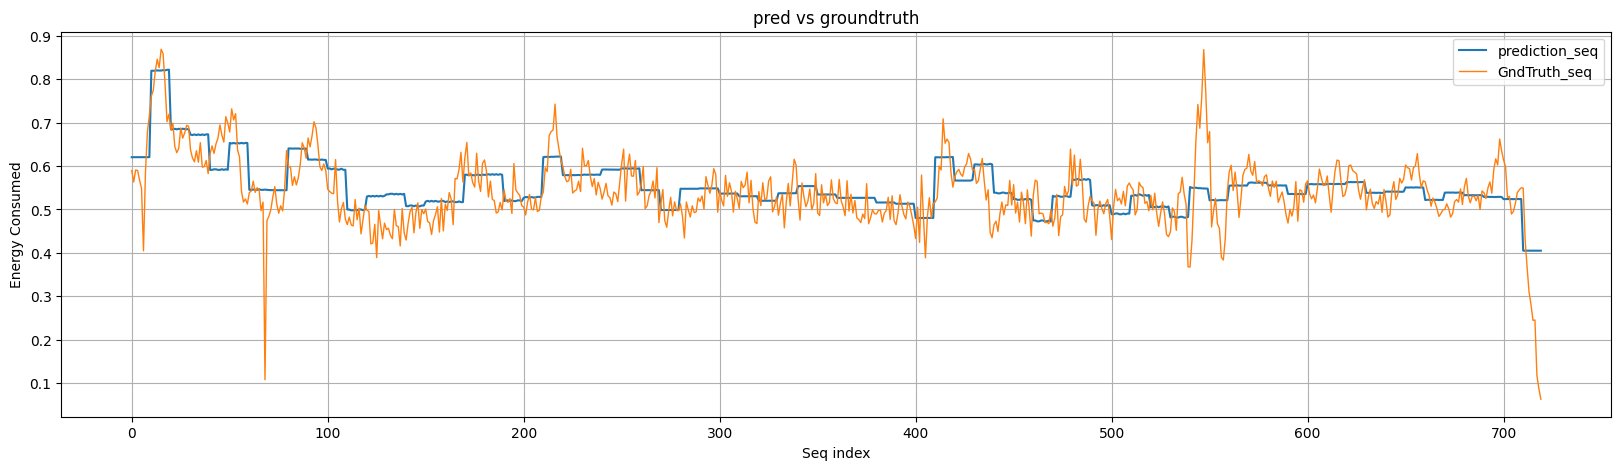

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

#model.load_state_dict(torch.load('/content/TCN_model_epoch_13_val_loss_0.0017.pt', map_location=torch.device('cpu')))
model.eval()

features = getFeatures(covariates=True)
print("features length = ", len(features))

flights_nums = d_split['test']
flight_num = random.choice(flights_nums)


print("flight_num = ", flight_num)
test_data = data[(data['flight'] == flight_num) & (data['power'] > 0.05)]


# Generate sequences
input_seq, output_seq = create_sequences(input_data=test_data[features].values, output_data=test_data['power'].values, input_seq_len=20, output_seq_len=10)

# Convert sequences to tensors and move to device
input_seq = torch.tensor(input_seq, dtype=torch.float32).to('cuda')  # Replace 'cpu' with 'cuda' if using GPU
output_seq = torch.tensor(output_seq, dtype=torch.float32).to('cuda')

mape_list = []

# Make predictions
with torch.no_grad():
    historical_features = input_seq[:, :, :-6]  # All but the last 6 columns
    covariates = input_seq[:, :num_outputs, -6:]          # Only the last 6 columns

    outputs = model(historical_features, covariates)

    targets = output_seq

    # Calculate error metrics
    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((targets - outputs) / (targets + 1e-8))) * 100
    print(f"MAPE: {mape.item()}")
    mape_list.append(mape)

    # Call the function with the outputs and targets
    #plot_output(outputs, targets, seq_len=2, focus_length=100)
    plot_output_old(outputs.cpu(), targets.cpu(), num_outputs)


features length =  13
flight_num =  201
Test loss: 0.0035091624595224857
MAPE: 9.57310676574707


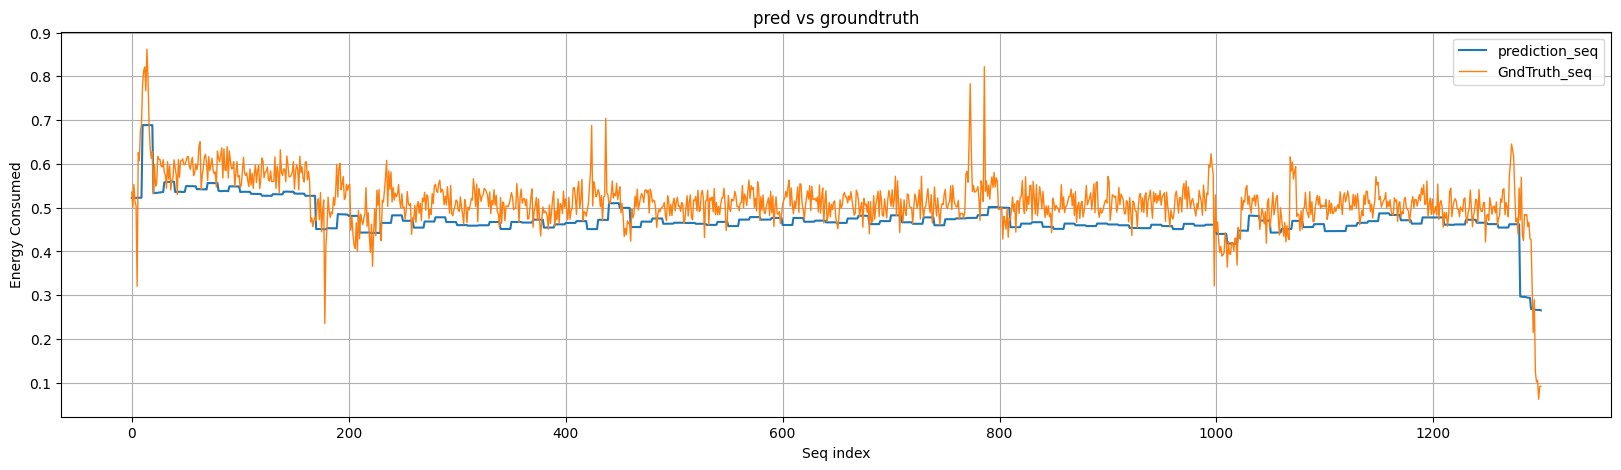

In [ ]:
# Predict Test with selected features model

import random
import numpy as np
import matplotlib.pyplot as plt

#model.load_state_dict(torch.load('/content/DeepTCN_selected_epoch_4_val_mape_33.0281.pt', map_location=torch.device('cpu')))
model.eval()

selected_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
selected_features += ['x_future', 'y_future', 'z_future' ,'x_change', 'y_change', 'z_change']

print("features length = ", len(selected_features))

flights_nums = d_split['test']
flight_num = random.choice(flights_nums)

print("flight_num = ", flight_num)
test_data = data[(data['flight'] == flight_num) & (data['power'] > 0.05)]


# Generate sequences
input_seq, output_seq = create_sequences(input_data=test_data[selected_features].values, output_data=test_data['power'].values, input_seq_len=20, output_seq_len=10)

# Convert sequences to tensors and move to device
input_seq = torch.tensor(input_seq, dtype=torch.float32).to('cuda')  # Replace 'cpu' with 'cuda' if using GPU
output_seq = torch.tensor(output_seq, dtype=torch.float32).to('cuda')

mape_list = []

# Make predictions
with torch.no_grad():
    historical_features = input_seq[:, :, :-6]  # All but the last 6 columns
    covariates = input_seq[:, :num_outputs, -6:]          # Only the last 6 columns

    outputs = model(historical_features, covariates)

    targets = output_seq

    # Calculate error metrics
    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((targets - outputs) / (targets + 1e-8))) * 100
    print(f"MAPE: {mape.item()}")
    mape_list.append(mape)

    # Call the function with the outputs and targets
    #plot_output(outputs, targets, seq_len=2, focus_length=100)
    plot_output_old(outputs.cpu(), targets.cpu(), num_outputs)


features length =  13


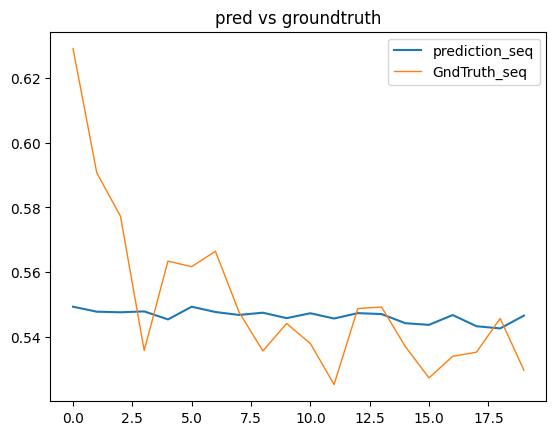

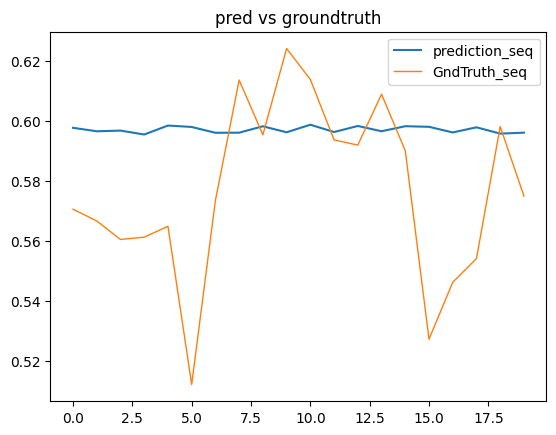

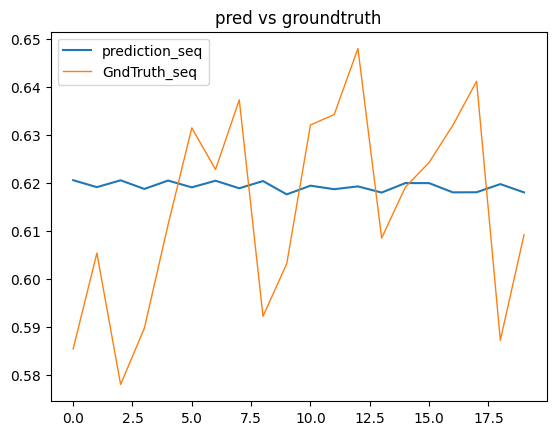

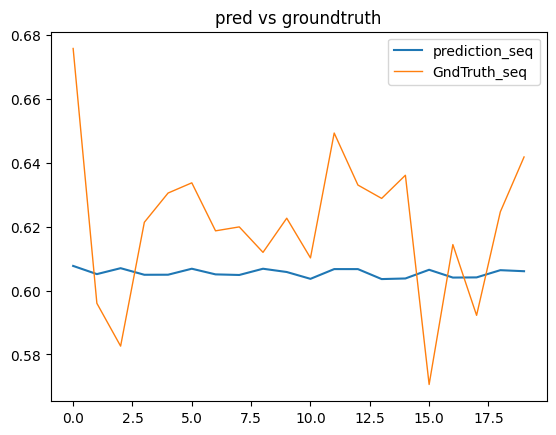

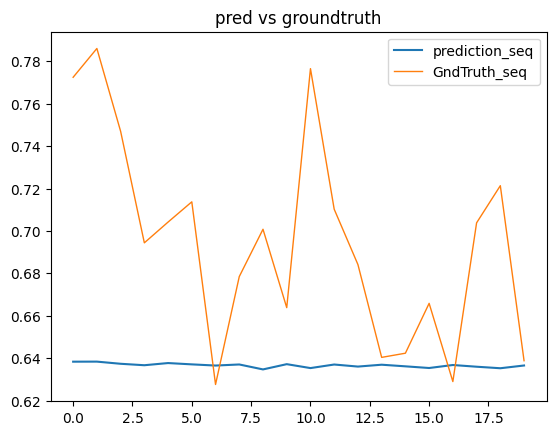

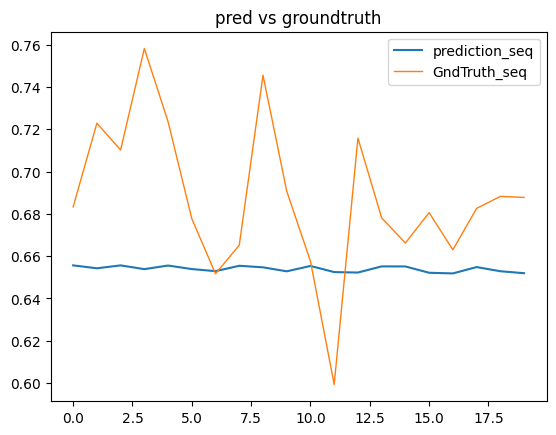

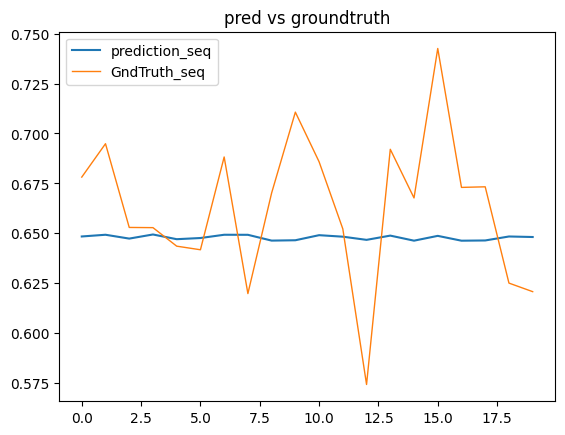

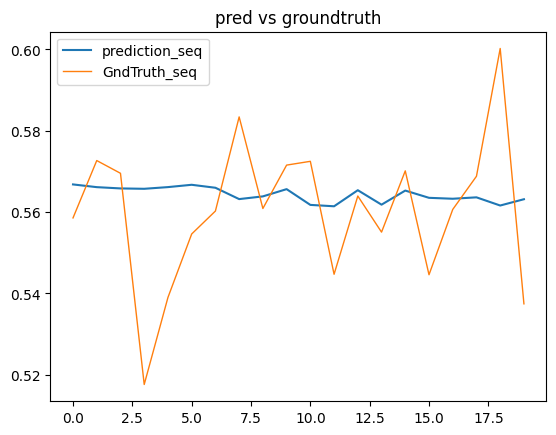

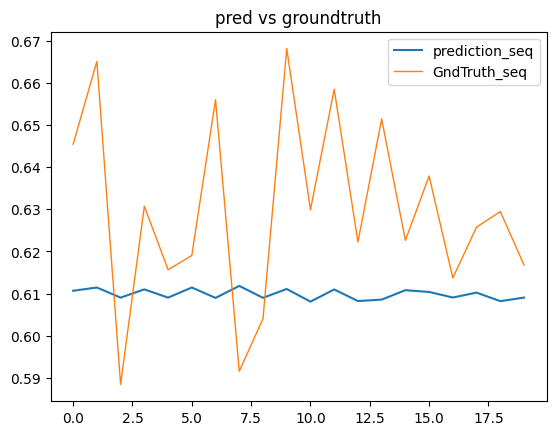

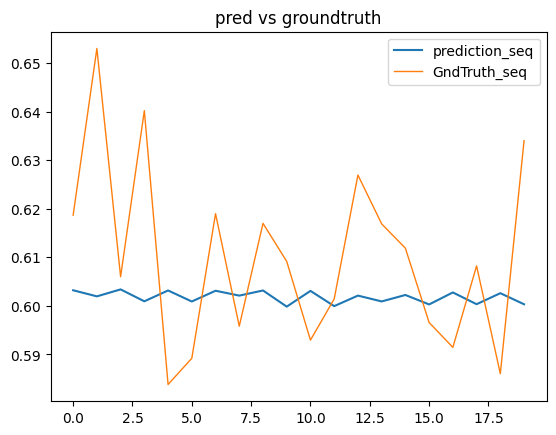

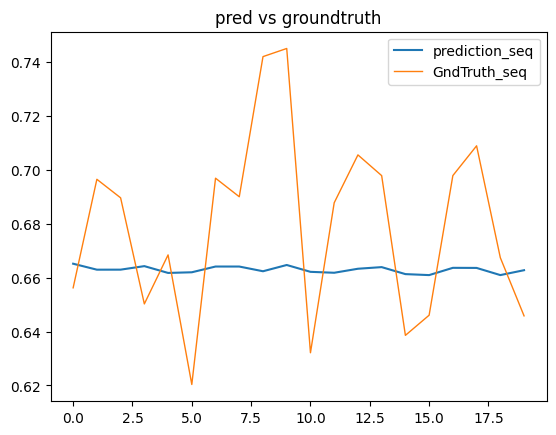

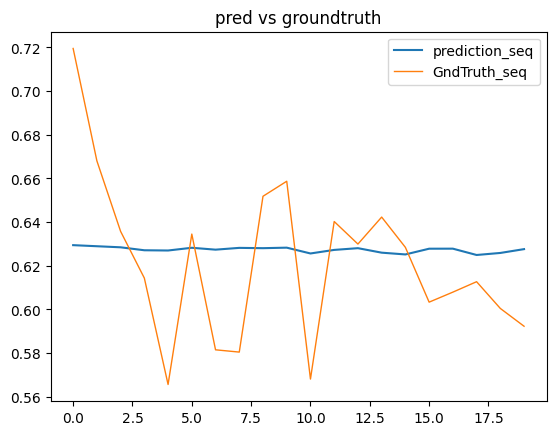

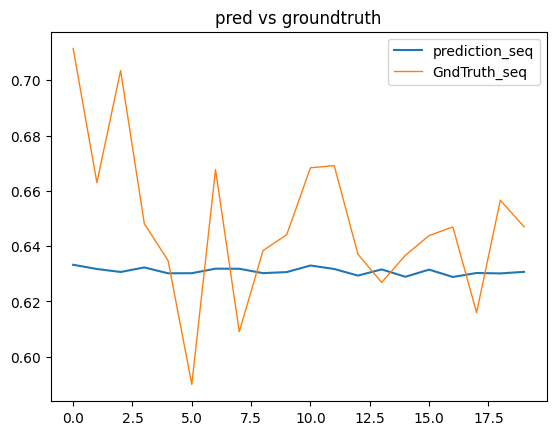

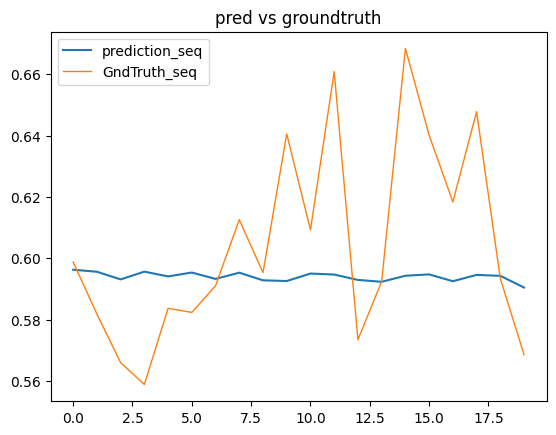

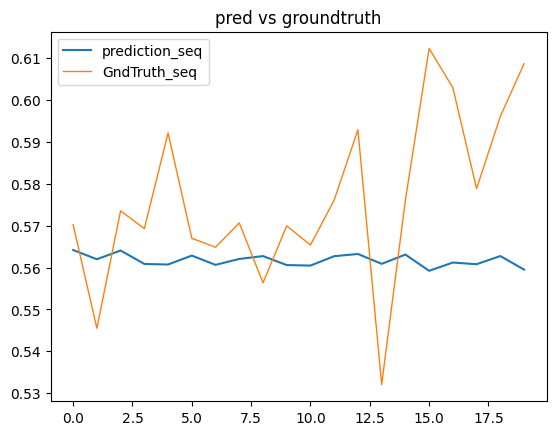

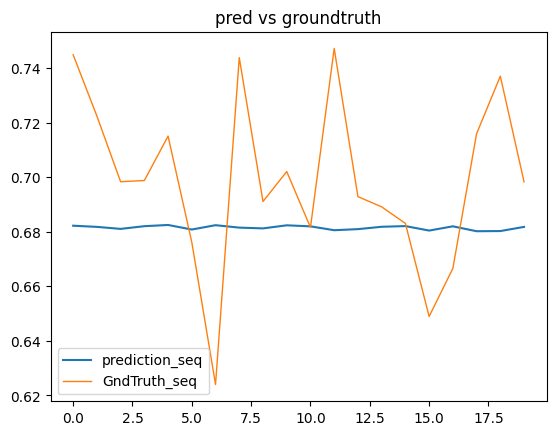

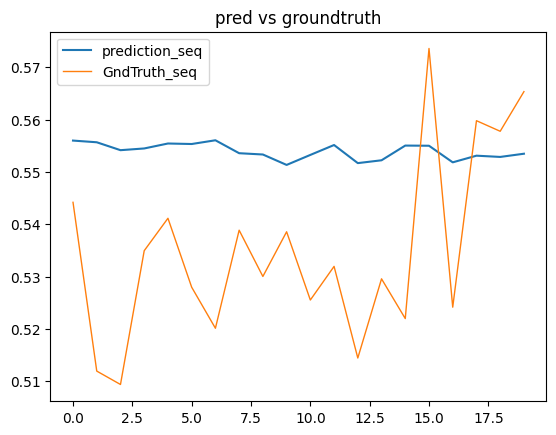

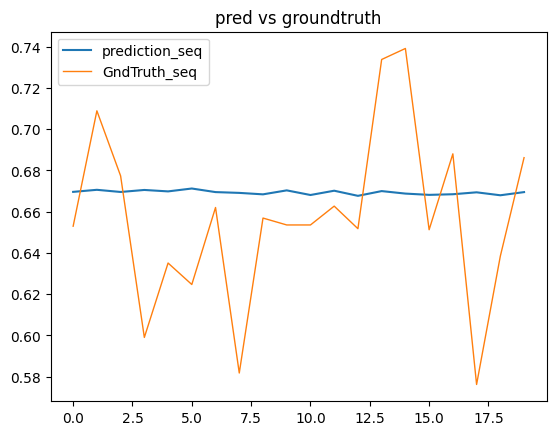

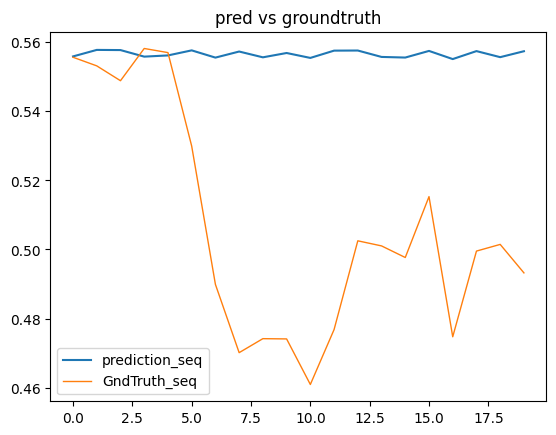

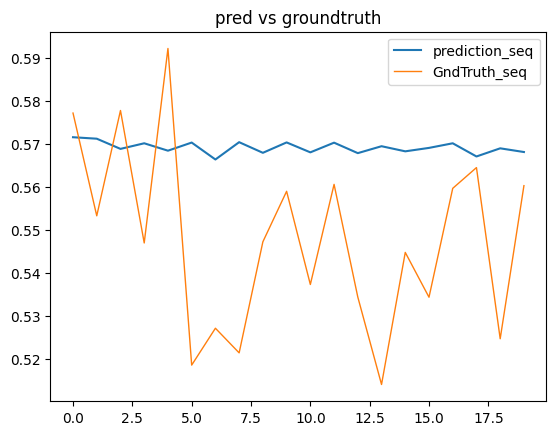

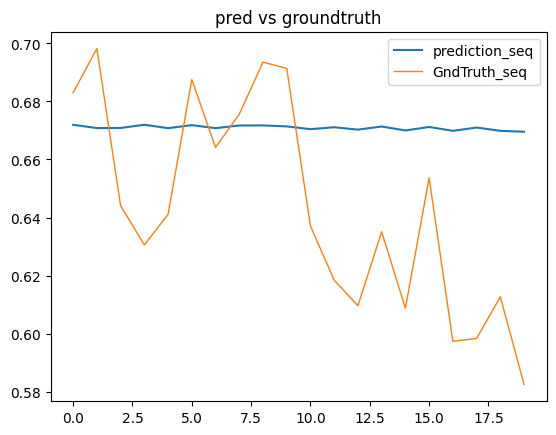

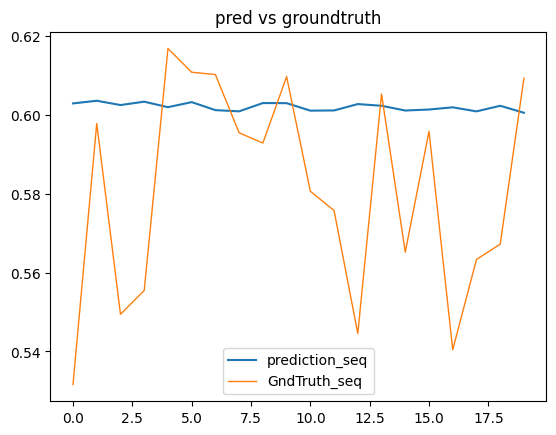

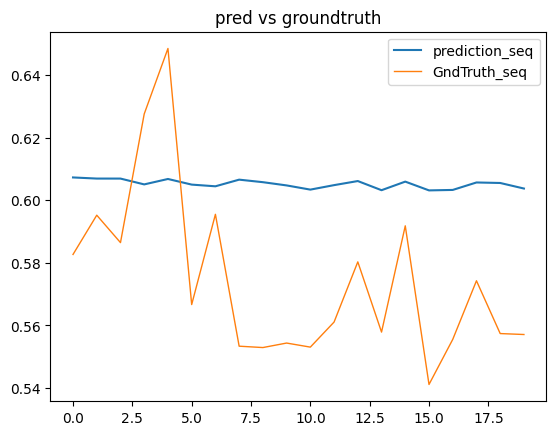

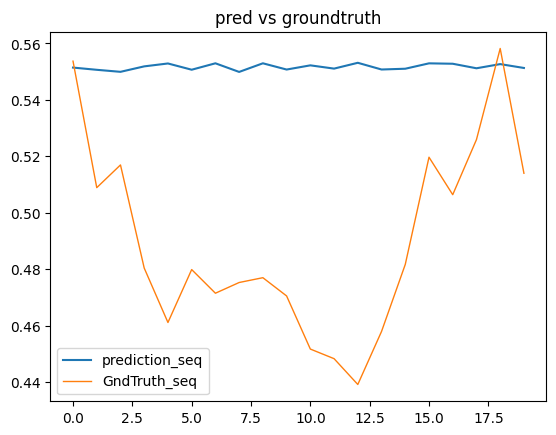

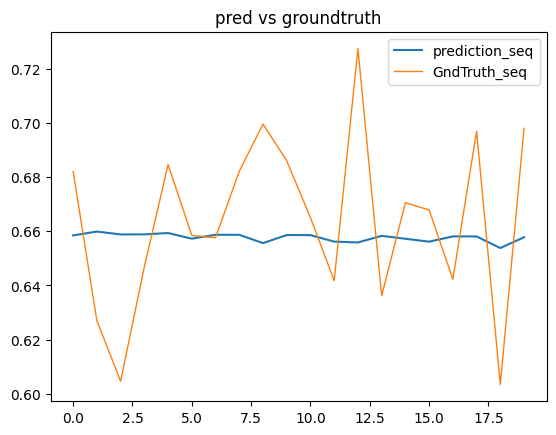

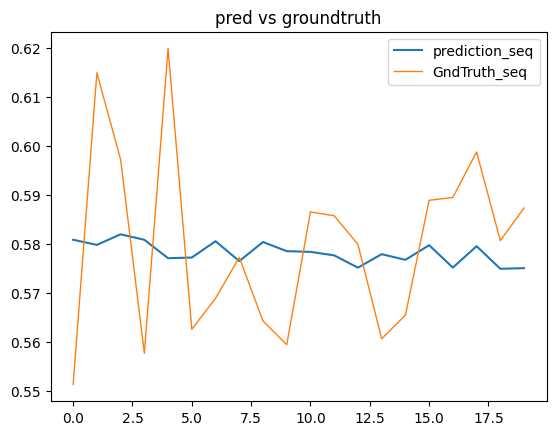

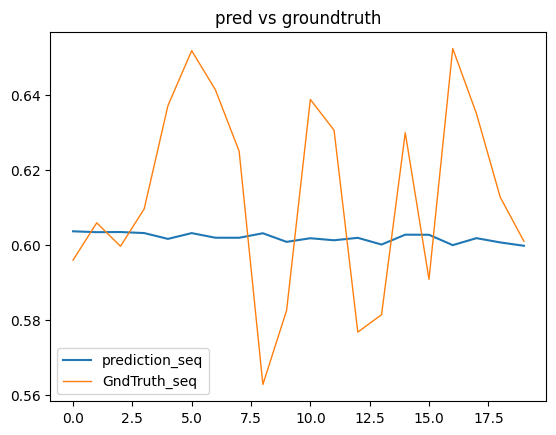

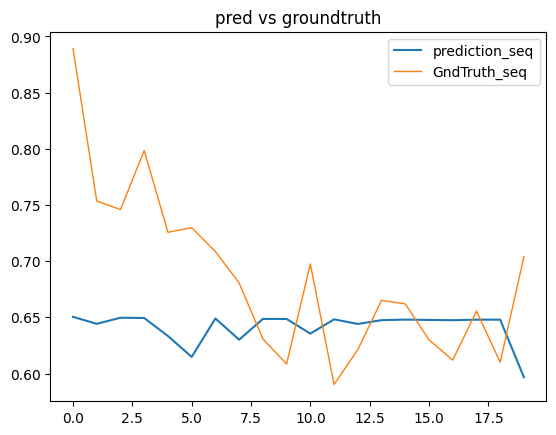

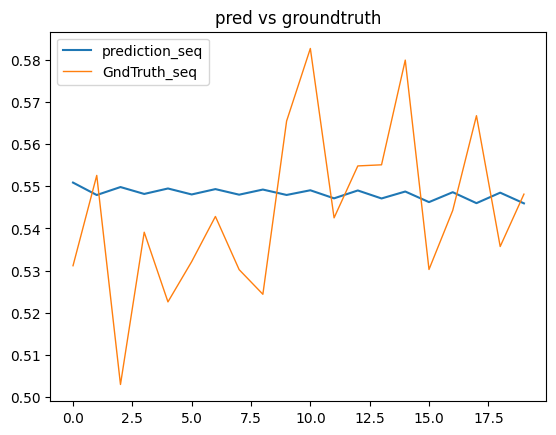

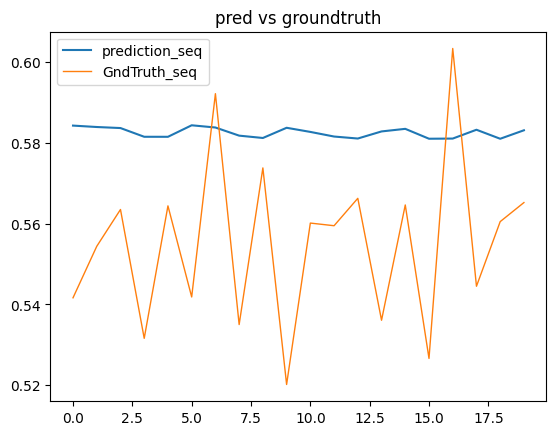

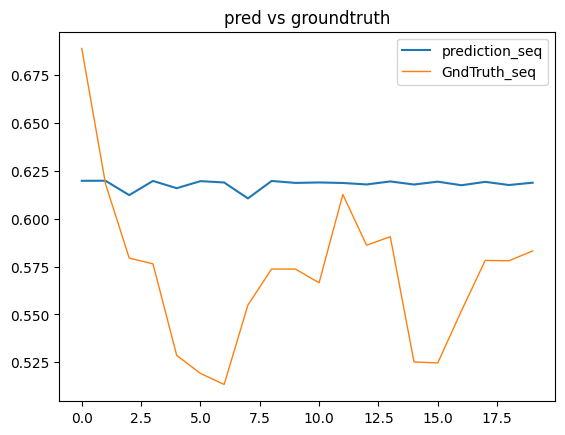

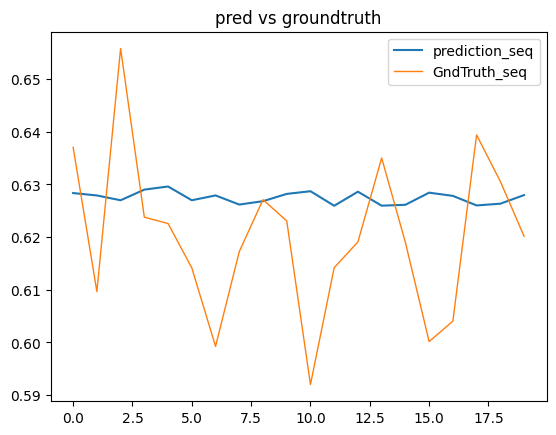

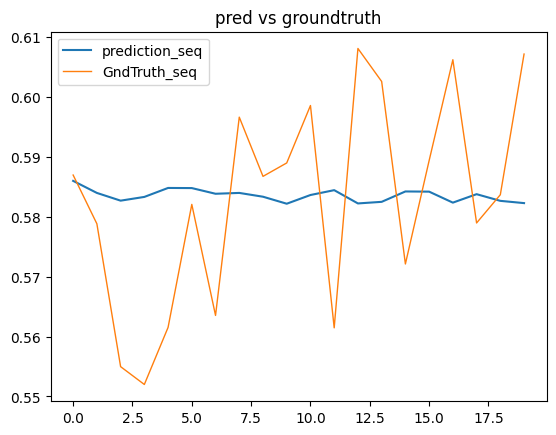

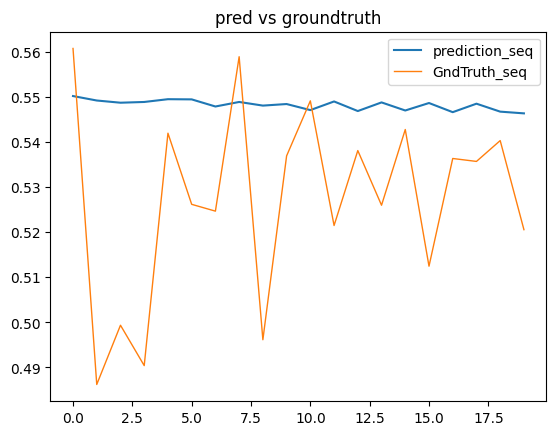

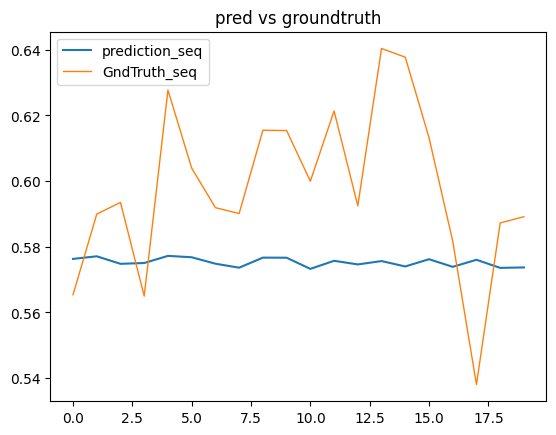

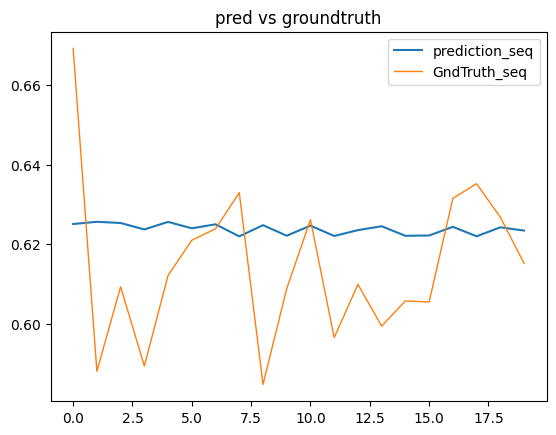

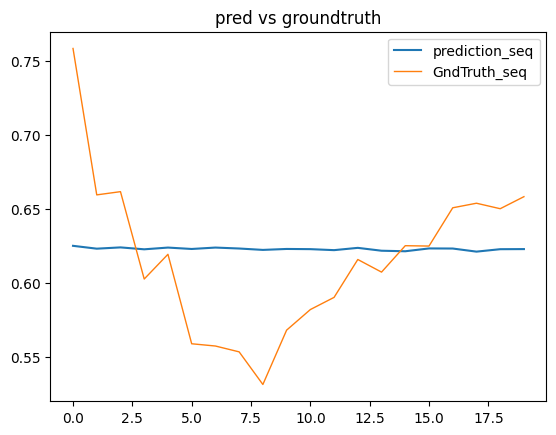

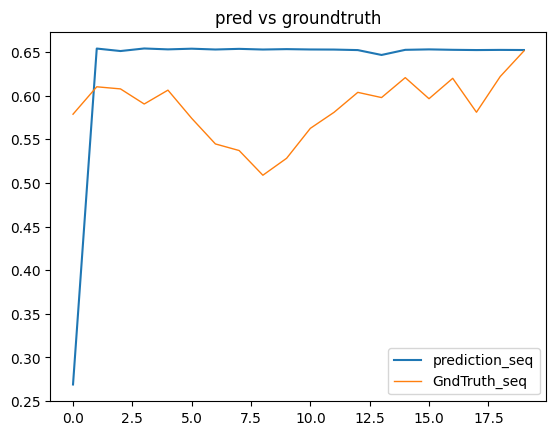

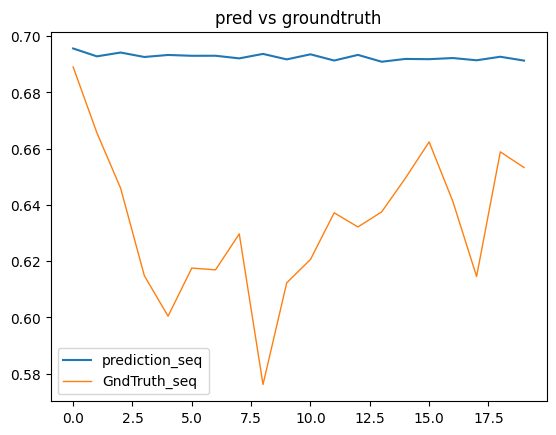

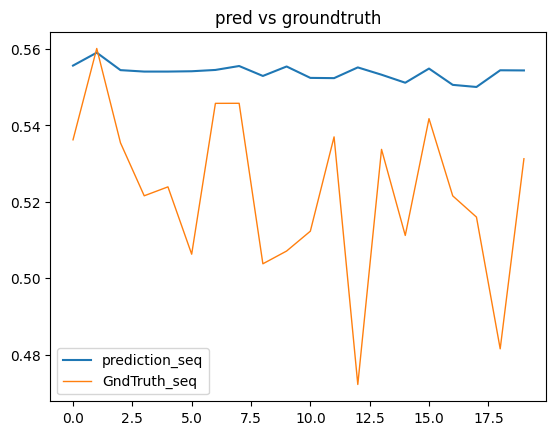

Average Huber Loss =  0.002156037639360875
Average MAE =  0.04679777361452579
Average R2 Score =  -1.2739177870750826
avg mape =  0.10451956670731306


In [18]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Define loss functions
huber_loss_function = nn.SmoothL1Loss()
mae_loss_function = nn.L1Loss()

# Lists to store metrics
huber_loss_list = []
mae_list = []
r2_score_list = []

#model.load_state_dict(torch.load('/content/DeepTCN_epoch_4_val_mape_21.7186.pt', map_location=torch.device('cpu')))
model.eval()
mape_list = []

selected_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power'] + ['x_future', 'y_future', 'z_future' ,'x_change', 'y_change', 'z_change']

print("features length = ", len(selected_features))

for flight_num in d_split['test']:
    test_data = data[(data['flight'] == flight_num) & (data['power'] > 0.05)]

    # Generate sequences
    input_seq, output_seq = create_sequences(input_data=test_data[selected_features].values, output_data=test_data['power'].values, input_seq_len=40, output_seq_len=20)

    # Convert sequences to tensors and move to device
    input_seq = torch.tensor(input_seq, dtype=torch.float32).to('cuda')  # Replace 'cpu' with 'cuda' if using GPU
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to('cuda')

    # Make predictions
    with torch.no_grad():
        #print(input_seq.shape)

        if input_seq.nelement() == 0:
            continue
        historical_features = input_seq[:, :, :-6]  # All but the last 6 columns
        covariates = input_seq[:, :num_outputs, -6:]          # Only the last 6 columns

        outputs = model(historical_features, covariates)
        targets = output_seq

        mape = torch.mean(torch.abs((targets - outputs) / (targets + 1e-8)))
        #print(f"MAPE: {mape.item()}")
        mape_list.append(mape.item())

        # Calculate Huber loss
        huber_loss = huber_loss_function(outputs, targets)
        huber_loss_list.append(huber_loss.item())

        # Calculate MAE
        mae = mae_loss_function(outputs, targets)
        mae_list.append(mae.item())

        # Calculate R2 Score
        # Note: Convert tensors to numpy arrays for sklearn metrics
        outputs_np = outputs.cpu().detach().numpy()
        targets_np = targets.cpu().detach().numpy()
        r2 = r2_score(targets_np.T, outputs_np.T, multioutput='raw_values')
        r2_score_list.extend(list(r2))
        
        plt.plot(outputs_np[0], label='prediction_seq')
        plt.plot(targets_np[0], label='GndTruth_seq', linewidth=1.0)
        plt.title('pred vs groundtruth')
        plt.legend()
        plt.show()

avg_huber_loss = sum(huber_loss_list) / len(huber_loss_list)
avg_mae = sum(mae_list) / len(mae_list)
avg_r2_score = sum(r2_score_list) / len(r2_score_list)

print("Average Huber Loss = ", avg_huber_loss)
print("Average MAE = ", avg_mae)
print("Average R2 Score = ", avg_r2_score)
print("avg mape = ", sum(mape_list) / len(mape_list))

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Define loss functions
huber_loss_function = nn.SmoothL1Loss()
mae_loss_function = nn.L1Loss()

# Lists to store metrics
huber_loss_list = []
mae_list = []
r2_score_list = []

#model.load_state_dict(torch.load('/content/DeepTCN_epoch_4_val_mape_21.7186.pt', map_location=torch.device('cpu')))
model.eval()
mape_list = []

features = getFeatures(covariates=True)

print("features length = ", len(features))

for flight_num in d_split['test']:
    test_data = data[(data['flight'] == flight_num) & (data['power'] > 0.05)]

    # Generate sequences
    input_seq, output_seq = create_sequences(input_data=test_data[features].values, output_data=test_data['power'].values, input_seq_len=40, output_seq_len=20)

    # Convert sequences to tensors and move to device
    input_seq = torch.tensor(input_seq, dtype=torch.float32).to('cuda')  # Replace 'cpu' with 'cuda' if using GPU
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to('cuda')

    # Make predictions
    with torch.no_grad():
        #print(input_seq.shape)

        if input_seq.nelement() == 0:
            continue
        historical_features = input_seq[:, :, :-6]  # All but the last 6 columns
        covariates = input_seq[:, :num_outputs, -6:]          # Only the last 6 columns

        outputs = model(historical_features, covariates)
        targets = output_seq

        #print(outputs.shape)
        #print(targets.shape)

        mape = torch.mean(torch.abs((targets - outputs) / (targets + 1e-8)))
        #print(f"MAPE: {mape.item()}")
        mape_list.append(mape.item())

        # Calculate Huber loss
        huber_loss = huber_loss_function(outputs, targets)
        huber_loss_list.append(huber_loss.item())

        # Calculate MAE
        mae = mae_loss_function(outputs, targets)
        mae_list.append(mae.item())

        # Calculate R2 Score
        # Note: Convert tensors to numpy arrays for sklearn metrics
        outputs_np = outputs.cpu().detach().numpy()
        targets_np = targets.cpu().detach().numpy()
        r2 = r2_score(targets_np, outputs_np)
        r2_score_list.append(r2)

avg_huber_loss = sum(huber_loss_list) / len(huber_loss_list)
avg_mae = sum(mae_list) / len(mae_list)
avg_r2_score = sum(r2_score_list) / len(r2_score_list)

print("Average Huber Loss = ", avg_huber_loss)
print("Average MAE = ", avg_mae)
print("Average R2 Score = ", avg_r2_score)
print("avg mape = ", sum(mape_list) / len(mape_list))

features length =  38
Average Huber Loss =  0.0026156989770242944
Average MAE =  0.04840259323827922
Average R2 Score =  0.017167996193725187
avg mape =  0.09897792227566242


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

# Define your model, ResidualBlock, Decoder, and DeepTCN (omitted for brevity)

def train_model(model, train_loader, criterion, optimizer, device, num_epochs, num_outputs):
    model.to(device)
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        total_loss = 0
        train_loader_with_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")
        for features, targets in train_loader_with_progress:
            historical_features = features[:, :, :-6].to(device)
            covariates = features[:, :num_outputs, -6:].to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(historical_features, covariates)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}')

def validate_model(model, val_loader, device, num_outputs):
    model.eval()  # Set the model to evaluation mode
    val_mape = 0
    val_loader_with_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation")
    with torch.no_grad():  # Disable gradient calculation
        for val_features, val_targets in val_loader_with_progress:
            val_historical_features = val_features[:, :, :-6].to(device)
            val_covariates = val_features[:, :num_outputs, -6:].to(device)
            val_targets = val_targets.to(device)

            val_outputs = model(val_historical_features, val_covariates)
            mape = torch.mean(torch.abs((val_targets - val_outputs) / (val_targets + 1e-8))) * 100
            val_mape += mape.item()

    avg_mape = val_mape / len(val_loader)
    return avg_mape

# Define hyperparameter search space
num_blocks_options = [2, 3, 4, 5, 6]
hidden_channels_options = [32, 64, 128, 256]

# Random Search Implementation
best_val_mape = float('inf')
best_hyperparams = {}
num_iterations = 5

for iteration in range(num_iterations):
    # Randomly sample hyperparameters
    num_blocks = random.choice(num_blocks_options)
    hidden_channels = random.choice(hidden_channels_options)

    # Instantiate the model with the selected hyperparameters
    model = DeepTCN(num_series=32, num_outputs=10, num_blocks=num_blocks,
                    kernel_size=3, hidden_channels=hidden_channels, num_covariates=6)

    # Define loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Train the model
    train_model(model, train_loader, criterion, optimizer, device, num_epochs=10, num_outputs=10)

    # Validate the model
    val_mape = validate_model(model, val_loader, device, num_outputs=10)
    print(f'Validation MAPE: {val_mape}')

    # Update best MAPE and hyperparameters if current model is better
    if val_mape < best_val_mape:
        best_val_mape = val_mape
        best_hyperparams = {
            'num_blocks': num_blocks,
            'kernel_size': kernel_size,
            'hidden_channels': hidden_channels
        }
        print(f"New best MAPE: {best_val_mape:.4f} with hyperparameters: {best_hyperparams}")

print(f"Best MAPE: {best_val_mape:.4f} with hyperparameters: {best_hyperparams}")

Epoch 1/10 Training: 100%|██████████| 2078/2078 [00:43<00:00, 47.32it/s]


Epoch 1/10, Loss: 0.009126945542166219


Epoch 2/10 Training: 100%|██████████| 2078/2078 [00:37<00:00, 55.20it/s]


Epoch 2/10, Loss: 0.004135466863939501


Epoch 3/10 Training: 100%|██████████| 2078/2078 [00:36<00:00, 57.09it/s]


Epoch 3/10, Loss: 0.00389433654246599


Epoch 4/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 62.43it/s]


Epoch 4/10, Loss: 0.00380565293148497


Epoch 5/10 Training: 100%|██████████| 2078/2078 [00:31<00:00, 65.84it/s]


Epoch 5/10, Loss: 0.0037514192362103514


Epoch 6/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 61.46it/s]


Epoch 6/10, Loss: 0.0036546228033010027


Epoch 7/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 63.45it/s]


Epoch 7/10, Loss: 0.003611970572311994


Epoch 8/10 Training:  68%|██████▊   | 1407/2078 [00:21<00:10, 65.13it/s]


KeyboardInterrupt: ignored

In [ ]:
import optuna

def objective(trial):
    # Define hyperparameter search space
    num_blocks_options = [2, 3, 4, 5, 6]
    hidden_channels_options = [32, 64, 128, 256]

    # Define hyperparameters using trial object
    num_blocks = trial.suggest_categorical('num_blocks', [2, 3, 4, 5, 6])
    hidden_channels = trial.suggest_categorical('hidden_channels', [32, 64, 128, 256])

    model = DeepTCN(num_series=32, num_outputs=10, num_blocks=num_blocks,
                    kernel_size=3, hidden_channels=hidden_channels, num_covariates=6)

    # Define loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Train the model
    train_model(model, train_loader, criterion, optimizer, device, num_epochs=10, num_outputs=10)

    # Validate the model
    val_mape = validate_model(model, val_loader, device, num_outputs=10)
    print(f'Validation MAPE: {val_mape}')

    val_mape = validate_model(model, val_loader, device, num_outputs=10)
    return val_mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Best trial:', study.best_trial.params)



[I 2023-12-10 05:46:05,499] A new study created in memory with name: no-name-90061ccb-3202-4bec-8e28-4271cb2a0aa8
Epoch 1/10 Training: 100%|██████████| 2078/2078 [00:38<00:00, 53.35it/s]


Epoch 1/10, Loss: 0.011518778279871895


Epoch 2/10 Training: 100%|██████████| 2078/2078 [00:38<00:00, 54.49it/s]


Epoch 2/10, Loss: 0.004360614325205819


Epoch 3/10 Training: 100%|██████████| 2078/2078 [00:38<00:00, 54.64it/s]


Epoch 3/10, Loss: 0.004193609925946068


Epoch 4/10 Training: 100%|██████████| 2078/2078 [00:37<00:00, 54.85it/s]


Epoch 4/10, Loss: 0.004050912073384468


Epoch 5/10 Training: 100%|██████████| 2078/2078 [00:37<00:00, 54.95it/s]


Epoch 5/10, Loss: 0.003935876514131151


Epoch 6/10 Training: 100%|██████████| 2078/2078 [00:36<00:00, 56.85it/s]


Epoch 6/10, Loss: 0.003781961446260017


Epoch 7/10 Training: 100%|██████████| 2078/2078 [00:38<00:00, 54.60it/s]


Epoch 7/10, Loss: 0.0037152788027470236


Epoch 8/10 Training: 100%|██████████| 2078/2078 [00:37<00:00, 54.90it/s]


Epoch 8/10, Loss: 0.003695110569421661


Epoch 9/10 Training: 100%|██████████| 2078/2078 [00:37<00:00, 55.98it/s]


Epoch 9/10, Loss: 0.0035229391926299885


Epoch 10/10 Training: 100%|██████████| 2078/2078 [00:37<00:00, 55.44it/s]


Epoch 10/10, Loss: 0.003486805576633902


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:07<00:00, 122.95it/s]


Validation MAPE: 50.69277047068966


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:06<00:00, 142.04it/s]
[I 2023-12-10 05:52:38,098] Trial 0 finished with value: 50.69277047068966 and parameters: {'num_blocks': 5, 'hidden_channels': 256}. Best is trial 0 with value: 50.69277047068966.
Epoch 1/10 Training: 100%|██████████| 2078/2078 [00:26<00:00, 78.65it/s]


Epoch 1/10, Loss: 0.007705370109172894


Epoch 2/10 Training: 100%|██████████| 2078/2078 [00:26<00:00, 78.72it/s]


Epoch 2/10, Loss: 0.0041157783970910845


Epoch 3/10 Training: 100%|██████████| 2078/2078 [00:26<00:00, 78.58it/s]


Epoch 3/10, Loss: 0.0038328757163928685


Epoch 4/10 Training: 100%|██████████| 2078/2078 [00:26<00:00, 78.64it/s]


Epoch 4/10, Loss: 0.0037196430861026666


Epoch 5/10 Training: 100%|██████████| 2078/2078 [00:26<00:00, 78.92it/s]


Epoch 5/10, Loss: 0.003671330954548764


Epoch 6/10 Training: 100%|██████████| 2078/2078 [00:26<00:00, 79.52it/s]


Epoch 6/10, Loss: 0.003612385655007539


Epoch 7/10 Training: 100%|██████████| 2078/2078 [00:26<00:00, 78.69it/s]


Epoch 7/10, Loss: 0.0035336343425324255


Epoch 8/10 Training: 100%|██████████| 2078/2078 [00:26<00:00, 78.49it/s]


Epoch 8/10, Loss: 0.003427696772781582


Epoch 9/10 Training: 100%|██████████| 2078/2078 [00:26<00:00, 78.46it/s]


Epoch 9/10, Loss: 0.00349800653620762


Epoch 10/10 Training: 100%|██████████| 2078/2078 [00:26<00:00, 78.87it/s]


Epoch 10/10, Loss: 0.0033557749880747593


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:04<00:00, 213.23it/s]


Validation MAPE: 81.02305243985337


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:04<00:00, 214.11it/s]
[I 2023-12-10 05:57:11,072] Trial 1 finished with value: 81.02305243985337 and parameters: {'num_blocks': 2, 'hidden_channels': 64}. Best is trial 0 with value: 50.69277047068966.
Epoch 1/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 62.23it/s]


Epoch 1/10, Loss: 0.010901735132908371


Epoch 2/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 63.86it/s]


Epoch 2/10, Loss: 0.004065369742062423


Epoch 3/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 62.20it/s]


Epoch 3/10, Loss: 0.003841125926216195


Epoch 4/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 63.98it/s]


Epoch 4/10, Loss: 0.003769762288943503


Epoch 5/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 63.96it/s]


Epoch 5/10, Loss: 0.0037617068209450538


Epoch 6/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 62.65it/s]


Epoch 6/10, Loss: 0.0036404703717873295


Epoch 7/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 64.93it/s]


Epoch 7/10, Loss: 0.003567974156963606


Epoch 8/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 62.12it/s]


Epoch 8/10, Loss: 0.0035628658529219537


Epoch 9/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 64.50it/s]


Epoch 9/10, Loss: 0.003454750740234637


Epoch 10/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 63.63it/s]


Epoch 10/10, Loss: 0.003437493153990276


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:05<00:00, 162.41it/s]


Validation MAPE: 29.522367561769038


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:05<00:00, 179.51it/s]
[I 2023-12-10 06:02:50,270] Trial 2 finished with value: 29.522367561769038 and parameters: {'num_blocks': 5, 'hidden_channels': 32}. Best is trial 2 with value: 29.522367561769038.
Epoch 1/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 61.25it/s]


Epoch 1/10, Loss: 0.010045661375025616


Epoch 2/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 63.63it/s]


Epoch 2/10, Loss: 0.004137139445557541


Epoch 3/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 61.52it/s]


Epoch 3/10, Loss: 0.003917388771942981


Epoch 4/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 63.32it/s]


Epoch 4/10, Loss: 0.003852181941543323


Epoch 5/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 61.42it/s]


Epoch 5/10, Loss: 0.003731159495007824


Epoch 6/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 63.27it/s]


Epoch 6/10, Loss: 0.0036209558726793033


Epoch 7/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 62.44it/s]


Epoch 7/10, Loss: 0.0035706287567235737


Epoch 8/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 62.84it/s]


Epoch 8/10, Loss: 0.00351580462377712


Epoch 9/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 63.64it/s]


Epoch 9/10, Loss: 0.0034672185650661846


Epoch 10/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 61.31it/s]


Epoch 10/10, Loss: 0.003415800976762826


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:05<00:00, 173.34it/s]


Validation MAPE: 48.12987640769871


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:06<00:00, 150.32it/s]
[I 2023-12-10 06:08:35,071] Trial 3 finished with value: 48.12987640769871 and parameters: {'num_blocks': 5, 'hidden_channels': 64}. Best is trial 2 with value: 29.522367561769038.
Epoch 1/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 63.36it/s]


Epoch 1/10, Loss: 0.007923239634212742


Epoch 2/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 61.84it/s]


Epoch 2/10, Loss: 0.0040115077891458755


Epoch 3/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 63.53it/s]


Epoch 3/10, Loss: 0.0038590756231736073


Epoch 4/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 61.95it/s]


Epoch 4/10, Loss: 0.00373734325544525


Epoch 5/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 63.13it/s]


Epoch 5/10, Loss: 0.0036259877121907814


Epoch 6/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 63.55it/s]


Epoch 6/10, Loss: 0.0036804769660997868


Epoch 7/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 62.18it/s]


Epoch 7/10, Loss: 0.0035409653825771432


Epoch 8/10 Training: 100%|██████████| 2078/2078 [00:32<00:00, 64.12it/s]


Epoch 8/10, Loss: 0.0034503725777972664


Epoch 9/10 Training: 100%|██████████| 2078/2078 [00:34<00:00, 61.08it/s]


Epoch 9/10, Loss: 0.0033978775440095866


Epoch 10/10 Training: 100%|██████████| 2078/2078 [00:33<00:00, 62.86it/s]


Epoch 10/10, Loss: 0.0033461644333389277


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:06<00:00, 147.72it/s]


Validation MAPE: 94.42865295688021


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:05<00:00, 174.48it/s]
[I 2023-12-10 06:14:18,380] Trial 4 finished with value: 94.42865295688021 and parameters: {'num_blocks': 5, 'hidden_channels': 64}. Best is trial 2 with value: 29.522367561769038.
Epoch 1/10 Training: 100%|██████████| 2078/2078 [00:29<00:00, 70.95it/s]


Epoch 1/10, Loss: 0.007526977681729645


Epoch 2/10 Training: 100%|██████████| 2078/2078 [00:29<00:00, 71.15it/s]


Epoch 2/10, Loss: 0.004122798465536522


Epoch 3/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 71.72it/s]


Epoch 3/10, Loss: 0.003918583815109749


Epoch 4/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 71.70it/s]


Epoch 4/10, Loss: 0.003750797568923947


Epoch 5/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 72.71it/s]


Epoch 5/10, Loss: 0.003667844534092838


Epoch 6/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 72.27it/s]


Epoch 6/10, Loss: 0.0036055014615060978


Epoch 7/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 72.79it/s]


Epoch 7/10, Loss: 0.0035421674032682145


Epoch 8/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 72.82it/s]


Epoch 8/10, Loss: 0.0035203580020862356


Epoch 9/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 73.24it/s]


Epoch 9/10, Loss: 0.0034547643577460384


Epoch 10/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 73.03it/s]


Epoch 10/10, Loss: 0.003335833254371545


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:05<00:00, 164.94it/s]


Validation MAPE: 21.910679850940525


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:04<00:00, 198.15it/s]
[I 2023-12-10 06:19:16,866] Trial 5 finished with value: 21.910679850940525 and parameters: {'num_blocks': 3, 'hidden_channels': 64}. Best is trial 5 with value: 21.910679850940525.
Epoch 1/10 Training: 100%|██████████| 2078/2078 [00:27<00:00, 75.04it/s]


Epoch 1/10, Loss: 0.014413808423154508


Epoch 2/10 Training: 100%|██████████| 2078/2078 [00:27<00:00, 74.32it/s]


Epoch 2/10, Loss: 0.004101119146207697


Epoch 3/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 74.14it/s]


Epoch 3/10, Loss: 0.003944930945199496


Epoch 4/10 Training: 100%|██████████| 2078/2078 [00:27<00:00, 74.36it/s]


Epoch 4/10, Loss: 0.003798391875816299


Epoch 5/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 74.10it/s]


Epoch 5/10, Loss: 0.003766714965848878


Epoch 6/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 74.00it/s]


Epoch 6/10, Loss: 0.003642499168659807


Epoch 7/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 73.87it/s]


Epoch 7/10, Loss: 0.0035515316398218237


Epoch 8/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 73.46it/s]


Epoch 8/10, Loss: 0.0034870499327305537


Epoch 9/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 73.76it/s]


Epoch 9/10, Loss: 0.0034937401887820897


Epoch 10/10 Training: 100%|██████████| 2078/2078 [00:27<00:00, 74.48it/s]


Epoch 10/10, Loss: 0.00348504038180939


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:04<00:00, 201.18it/s]


Validation MAPE: 104.16888992198425


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:05<00:00, 180.98it/s]
[I 2023-12-10 06:24:07,327] Trial 6 finished with value: 104.16888992198425 and parameters: {'num_blocks': 3, 'hidden_channels': 32}. Best is trial 5 with value: 21.910679850940525.
Epoch 1/10 Training: 100%|██████████| 2078/2078 [00:29<00:00, 70.15it/s]


Epoch 1/10, Loss: 0.00899828891059217


Epoch 2/10 Training: 100%|██████████| 2078/2078 [00:29<00:00, 70.60it/s]


Epoch 2/10, Loss: 0.004347709403081983


Epoch 3/10 Training: 100%|██████████| 2078/2078 [00:29<00:00, 70.86it/s]


Epoch 3/10, Loss: 0.004081142645836131


Epoch 4/10 Training: 100%|██████████| 2078/2078 [00:29<00:00, 71.59it/s]


Epoch 4/10, Loss: 0.0039181383733935225


Epoch 5/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 72.18it/s]


Epoch 5/10, Loss: 0.0037401550319121975


Epoch 6/10 Training: 100%|██████████| 2078/2078 [00:29<00:00, 71.07it/s]


Epoch 6/10, Loss: 0.0036066553817167375


Epoch 7/10 Training: 100%|██████████| 2078/2078 [00:30<00:00, 69.20it/s]


Epoch 7/10, Loss: 0.003640041371970594


Epoch 8/10 Training: 100%|██████████| 2078/2078 [00:28<00:00, 71.67it/s]


Epoch 8/10, Loss: 0.0035350446610467705


Epoch 9/10 Training: 100%|██████████| 2078/2078 [00:29<00:00, 71.64it/s]


Epoch 9/10, Loss: 0.003413144494077465


Epoch 10/10 Training: 100%|██████████| 2078/2078 [00:29<00:00, 71.53it/s]


Epoch 10/10, Loss: 0.0033936735743560842


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:05<00:00, 186.15it/s]


Validation MAPE: 38.22028945363151


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:05<00:00, 174.97it/s]
[I 2023-12-10 06:29:10,619] Trial 7 finished with value: 38.22028945363151 and parameters: {'num_blocks': 3, 'hidden_channels': 128}. Best is trial 5 with value: 21.910679850940525.
Epoch 1/10 Training: 100%|██████████| 2078/2078 [00:35<00:00, 58.56it/s]


Epoch 1/10, Loss: 0.01123836001838872


Epoch 2/10 Training: 100%|██████████| 2078/2078 [00:35<00:00, 57.89it/s]


Epoch 2/10, Loss: 0.0040573757253313854


Epoch 3/10 Training: 100%|██████████| 2078/2078 [00:36<00:00, 57.59it/s]


Epoch 3/10, Loss: 0.003968190669973539


Epoch 4/10 Training: 100%|██████████| 2078/2078 [00:34<00:00, 59.81it/s]


Epoch 4/10, Loss: 0.0038203690198242942


Epoch 5/10 Training: 100%|██████████| 2078/2078 [00:35<00:00, 58.17it/s]


Epoch 5/10, Loss: 0.003685778104727039


Epoch 6/10 Training: 100%|██████████| 2078/2078 [00:36<00:00, 57.33it/s]


Epoch 6/10, Loss: 0.003590609415665563


Epoch 7/10 Training: 100%|██████████| 2078/2078 [00:35<00:00, 59.04it/s]


Epoch 7/10, Loss: 0.003602157829148306


Epoch 8/10 Training: 100%|██████████| 2078/2078 [00:36<00:00, 57.60it/s]


Epoch 8/10, Loss: 0.0035588892397589093


Epoch 9/10 Training: 100%|██████████| 2078/2078 [00:35<00:00, 58.23it/s]


Epoch 9/10, Loss: 0.0034661464640983633


Epoch 10/10 Training: 100%|██████████| 2078/2078 [00:35<00:00, 58.81it/s]


Epoch 10/10, Loss: 0.003452831405081407


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:06<00:00, 144.27it/s]


Validation MAPE: 65.5462934353101


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:05<00:00, 163.92it/s]
[I 2023-12-10 06:35:19,734] Trial 8 finished with value: 65.5462934353101 and parameters: {'num_blocks': 6, 'hidden_channels': 64}. Best is trial 5 with value: 21.910679850940525.
Epoch 1/10 Training: 100%|██████████| 2078/2078 [00:30<00:00, 68.79it/s]


Epoch 1/10, Loss: 0.007630928365972621


Epoch 2/10 Training: 100%|██████████| 2078/2078 [00:30<00:00, 67.13it/s]


Epoch 2/10, Loss: 0.004065458225045995


Epoch 3/10 Training: 100%|██████████| 2078/2078 [00:29<00:00, 69.46it/s]


Epoch 3/10, Loss: 0.0038734861281839368


Epoch 4/10 Training: 100%|██████████| 2078/2078 [00:30<00:00, 68.98it/s]


Epoch 4/10, Loss: 0.0037804765281015586


Epoch 5/10 Training: 100%|██████████| 2078/2078 [00:30<00:00, 68.84it/s]


Epoch 5/10, Loss: 0.0037223705561397753


Epoch 6/10 Training: 100%|██████████| 2078/2078 [00:30<00:00, 67.62it/s]


Epoch 6/10, Loss: 0.0036359321574422356


Epoch 7/10 Training: 100%|██████████| 2078/2078 [00:30<00:00, 68.28it/s]


Epoch 7/10, Loss: 0.003593674471648455


Epoch 8/10 Training: 100%|██████████| 2078/2078 [00:30<00:00, 68.84it/s]


Epoch 8/10, Loss: 0.0034986041259146955


Epoch 9/10 Training: 100%|██████████| 2078/2078 [00:29<00:00, 69.75it/s]


Epoch 9/10, Loss: 0.003452181864728841


Epoch 10/10 Training: 100%|██████████| 2078/2078 [00:30<00:00, 67.41it/s]


Epoch 10/10, Loss: 0.0034428728169369886


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:05<00:00, 169.97it/s]


Validation MAPE: 28.374560223161616


Epoch 20/20 Validation: 100%|██████████| 961/961 [00:05<00:00, 189.30it/s]
[I 2023-12-10 06:40:33,944] Trial 9 finished with value: 28.374560223161616 and parameters: {'num_blocks': 4, 'hidden_channels': 32}. Best is trial 5 with value: 21.910679850940525.


Best trial: {'num_blocks': 3, 'hidden_channels': 64}
